<a href="https://colab.research.google.com/github/MinSeok1o28/MS_K/blob/main/Parking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##광진구 데이터공모전

In [1]:
#google drive 연결
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#!apt -qq -y install fonts-nanum
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/n

In [3]:
#패키지
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import folium
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
%matplotlib inline
import matplotlib.font_manager as fm
font_path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font_manager.FontProperties(fname=font_path, size=9)
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['font.family'] = 'NanumBarunGothic' # 나눔바른고딕 적용하기

##1. 데이터 전처리


> 종속변수: 주정차 단속현황(enforcement_count)

> 독립변수: CCTV위치(cctv_dong), 공영주차장(count_parking_public), 노상/노외주차장(count_parking_concated)





##1-1) 데이터 전처리: 단속현황

In [4]:
#2022 ~ 2023년도 단속현황
df1 = pd.read_csv('/content/drive/MyDrive/GwangJin/Parking/서울특별시 광진구_주정차단속현황_20230228.csv', encoding = 'cp949')
df1['단속일시'] = pd.to_datetime(df1['단속일시'], format = '%Y-%m-%d %H:%M:%S')
df_2023 = df1[['단속일시', '단속동', '단속장소']]
df_2023.head()

,단속일시,단속동,단속장소
0,2022-01-01 02:29:00,중곡동,서울특별시 광진구 영화사로5길 19
1,2022-01-01 06:41:00,중곡동,150-196
2,2022-01-01 07:02:00,구의동,서울 광진구 구의동 660-1 주차장앞
3,2022-01-01 07:29:00,구의동,서울 광진구 구의동 6-4
4,2022-01-01 10:55:00,구의동,리젠트오피스텔건너편


In [5]:
#단속동 정리(2022~2023년)
dong = ['자양동', '중곡동', '광장동', '구의동', '군자동', '화양동', '능동']
enforcement_dong_2023 = df_2023[df_2023['단속동'].isin(dong)]
enforcement_count_2023 = pd.DataFrame(columns = ['단속동'])
enforcement_count_2023['단속동'] = enforcement_dong_2023['단속동'].value_counts()
enforcement_count_2023

,단속동
구의동,10033
중곡동,9366
자양동,7859
광장동,4671
군자동,2937
화양동,2561
능동,2283


In [6]:
#2015 ~ 2022년도 단속현황
df2 = pd.read_csv('/content/drive/MyDrive/GwangJin/Parking/서울특별시 광진구_주정차 단속현황_20220610.csv', encoding = 'cp949')
df2['단속일시'] = pd.to_datetime(df2['단속일시'], format = '%Y-%m-%d %H:%M:%S')
df_2015_2022 = df2[['단속일시', '단속동', '단속장소']]
df_2015_2022.head()

,단속일시,단속동,단속장소
0,2015-01-01 06:44:00,화양동,119-4
1,2015-01-01 07:01:00,화양동,건대입구1번출구앞
2,2015-01-01 07:24:00,구의동,동서울터미널 주차장앞
3,2015-01-01 08:00:00,화양동,건대입구1번출구앞
4,2015-01-01 08:15:00,화양동,건대입구1번출구앞


In [7]:
#단속현황 데이터 병합(2015~2023년)
concated_df = pd.concat([df1, df2]).drop_duplicates()
concated_df['단속일시'] = pd.to_datetime(concated_df['단속일시'], format = '%Y-%m-%d %H:%M:%S')
concated_df = concated_df[['단속일시', '단속동', '단속장소']]

In [8]:
#단속동 정리(2015~2023년)
dong = ['자양동', '중곡동', '광장동', '구의동', '군자동', '화양동', '능동']
enforcement_dong = concated_df[concated_df['단속동'].isin(dong)]
enforcement_count = pd.DataFrame(columns = ['단속동'])
enforcement_count['단속동'] = enforcement_dong['단속동'].value_counts()
enforcement_count

,단속동
구의동,115831
자양동,88661
중곡동,81926
화양동,48668
광장동,41501
군자동,33355
능동,16558


In [9]:
concated_df['month'] = concated_df['단속일시'].dt.month
concated_df.head()

,단속일시,단속동,단속장소,month
0,2022-01-01 02:29:00,중곡동,서울특별시 광진구 영화사로5길 19,1
1,2022-01-01 06:41:00,중곡동,150-196,1
2,2022-01-01 07:02:00,구의동,서울 광진구 구의동 660-1 주차장앞,1
3,2022-01-01 07:29:00,구의동,서울 광진구 구의동 6-4,1
4,2022-01-01 10:55:00,구의동,리젠트오피스텔건너편,1


In [10]:
#년도별 단속현황 데이터 요약
by_year = concated_df.groupby(concated_df.단속일시.dt.year)['단속동'].count()
by_year = pd.DataFrame(by_year)
by_year = by_year.rename(columns = {'단속동' : '년도별 단속 횟수'})
by_year.tail(3)

,년도별 단속 횟수
단속일시,
2021,56761
2022,55811
2023,4005


In [11]:
#월별 단속현황 데이터 요약
monthly = concated_df.groupby(concated_df.단속일시.dt.month)['단속동'].count()
monthly = pd.DataFrame(monthly)
monthly = monthly.rename(columns = {'단속동' : '월별 단속 횟수'})
monthly.head(3)

,월별 단속 횟수
단속일시,
1,44791
2,39491
3,46124


In [12]:
#시간별 단속 빈도 요약
by_hour = concated_df.groupby(concated_df.단속일시.dt.hour)['단속동'].count()
by_hour = pd.DataFrame(by_hour)
by_hour = by_hour.rename(columns = {'단속동' : '시간별 단속 횟수'})
by_hour.head(3)

,시간별 단속 횟수
단속일시,
0,10554
1,5494
2,3619


##1-2) 데이터 전처리: 불법주정차 위반 단속 CCTV

In [13]:
#불법주정차 위반 단속 CCTV 위치데이터
cctv = pd.read_csv('/content/drive/MyDrive/GwangJin/Parking/서울시 광진구 불법주정차 위반 단속 CCTV 위치정보.csv', encoding = 'cp949')
cctv.head()

,고정형CCTV지번주소,위도,경도,자치구,단속지점명,현장구분
0,서울 광진구 광장동 334-2,37.547790,127.106990,광진구,SK강평주유소 앞,불법주정차구역
1,서울 광진구 광장동 445-3,37.543799,127.102410,광진구,광현교회 앞,불법주정차구역
2,서울 광진구 구의동 135,37.549593,127.081780,광진구,아차산역 5번출구 앞,불법주정차구역
3,서울 광진구 군자동 503,37.548609,127.071072,광진구,두산위브 앞,불법주정차구역
4,서울 광진구 구의동 66-62,37.545348,127.088420,광진구,국민은행 앞,불법주정차구역


In [14]:
#동별 CCTV 개수(2015~2023년)
cctv_dong = cctv.groupby(cctv['고정형CCTV지번주소'].str.split(' ').str[2])[['위도']].count()
cctv_dong = cctv_dong.rename(columns = {'위도' : 'cctv개수'})
cctv_dong

,cctv개수
고정형CCTV지번주소,
광장동,4
구의동,16
군자동,6
능동,3
자양동,13
중곡동,12
화양동,4


In [15]:
#CCTV와 주정차단속 상관관계(2015 ~ 2023 통합 데이터 기준)
corr_2015 = enforcement_count['단속동'].corr(cctv_dong['cctv개수'], method = 'pearson')
corr_2015

0.9578933724577856

In [16]:
#CCTV와 주정차단속 상관관계(2022 ~ 2023 데이터 기준)
corr_2023 = enforcement_count_2023['단속동'].corr(cctv_dong['cctv개수'], method = 'pearson')
corr_2023

0.9440750504476976

**1-2 시사점**

> **CCTV와 주정차단속 상관관계는
0.95로 매우 높음**



## 1-3) 데이터 전처리: 공영주차장

In [17]:
#공영주차장 개수
parking_public = pd.read_csv('/content/drive/MyDrive/GwangJin/Parking/서울특별시 광진구_공영주차장 정보_20220118.csv', encoding = 'cp949')
parking_public.head()

,연번,운영개시일,동명,시설명,위치,부지면적,주차면수 소계,주차면수 노상,주차면수 노외,거주자,공영,급지,주차요금 5분당,주차요금 주간,주차요금 야간,주차요금 종일,시설규모,비고
0,1,Sep-10,중곡1동,중곡제일전통시장 공영,중곡1동 221-6,695,21,0.0,21.0,NaN,O,2,250원,NaN,3만원,NaN,NaN,구유지(지역경제과·위탁)
1,2,Mar-98,중곡2동,장신구,중곡2동 133-10,531,22,0.0,22.0,O,NaN,5,NaN,4만원,3만원,5만원,NaN,시유지
2,3,Jun-99,중곡2동,중곡동복개천,중곡2동 150-196,NaN,78,78.0,0.0,NaN,O,2,200원,NaN,NaN,10만원,NaN,시유도로(노상·공단위탁)
3,4,Apr-09,중곡3동,중곡3동마을공원,중곡3동 195-1,3038.3,162,NaN,162.0,O,O,5,75원,4만원,3만원,5만원,지하2층,구유지
4,5,Jan-10,중곡3동,중곡체육센터,중곡3동 168-8,"3,690.00",6,NaN,6.0,O,NaN,5,NaN,4만원,3만원,5만원,NaN,구유지


In [18]:
#공영주차장 동명 정리
for i in parking_public.index:
  if parking_public.loc[i, '동명'].startswith('중곡'):
    parking_public.loc[i, '동명'] = '중곡동'
  elif parking_public.loc[i, '동명'].startswith('구의'):
    parking_public.loc[i, '동명'] = '구의동'
  elif parking_public.loc[i, '동명'].startswith('자양'):
    parking_public.loc[i, '동명'] = '자양동'

count_parking_public = pd.DataFrame(columns = ['동명'])
count_parking_public['동명'] = parking_public['동명'].value_counts()
count_parking_public

,동명
중곡동,13
구의동,8
자양동,5
광장동,3
화양동,3
능동,2
군자동,2


In [19]:
#공영주차장과 주정차단속 상관관계 (2015 ~ 2023 데이터 기준)
corr_parking_public = enforcement_count['단속동'].corr(count_parking_public['동명'], method = 'pearson')
corr_parking_public

0.711527474987588

In [20]:
#공영주차장과 주정차단속 상관관계 (2022 ~ 2023 데이터 기준)
corr_parking_public = enforcement_count_2023['단속동'].corr(count_parking_public['동명'], method = 'pearson')
corr_parking_public

0.8500672373333371

**1-3 시사점**

> **공영주차장이 많은 곳에 불법주정차도 많음**


> 공영주차장이 예전보다 더욱 부족하다는 것으로 해석(2015년부터 집계한 데이터보다 최근 데이터와의 상관관계가 유의미하게 높아졌으므로)





## 1-4) 데이터 전처리: 노상 및 노외주차장

In [21]:
#노상주차장(df3), 노외주차장(df4)
df3 = pd.read_csv('/content/drive/MyDrive/GwangJin/Parking/노상주차장.csv')
df4 = pd.read_csv('/content/drive/MyDrive/GwangJin/Parking/노외주차장.csv')

#주소를 동명으로 변경
df3['주소(지번)(lot_num_address)'] = df3.loc[:, '주소(지번)(lot_num_address)'].str.split(' ').str[2]
df4['주소(지번)(lot_num_address)'] = df4.loc[:, '주소(지번)(lot_num_address)'].str.split(' ').str[2]

#노상주차장 데이터 정제(주소 정리)
for i in df3.index:
  if df3.loc[i, '주소(지번)(lot_num_address)'].startswith('자양'):
    df3.loc[i, '주소(지번)(lot_num_address)'] = '자양동'

In [22]:
#노상/노외주차장 동별 개수
parking_concated = pd.concat([df3, df4]).drop_duplicates()
count_parking_concated = pd.DataFrame(columns = ['주소(지번)'])
count_parking_concated['주소(지번)'] = parking_concated['주소(지번)(lot_num_address)'].value_counts()
count_parking_concated

,주소(지번)
자양동,1003
중곡동,688
구의동,339
광장동,190
능동,162
화양동,158
군자동,52


In [23]:
#노상/노외주차장과 주정차단속 상관관계 (2015 ~ 2023 데이터 기준)
corr_parking_concated = enforcement_count['단속동'].corr(count_parking_concated['주소(지번)'], method = 'pearson')
corr_parking_concated

0.6332900486488339

In [24]:
#노상/노외주차장과 주정차단속 상관관계 (2022 ~ 2023 데이터 기준)
corr_parking_concated_2023 = enforcement_count_2023['단속동'].corr(count_parking_concated['주소(지번)'], method = 'pearson')
corr_parking_concated_2023

0.6939485183279449

In [25]:
cctv_lat = cctv['위도']
cctv_long = cctv['경도']

#2. 시각화: 불법주정차 단속 현황

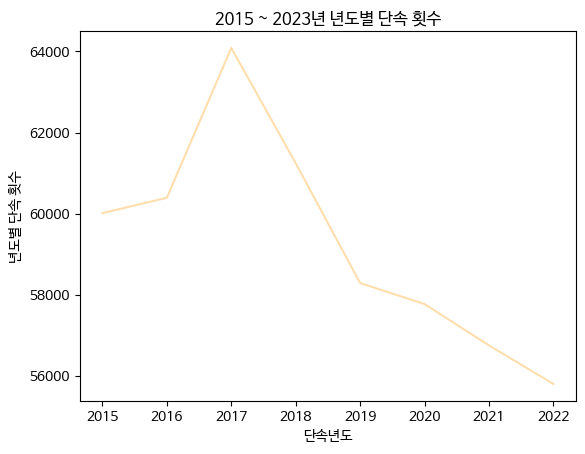

In [28]:
#년도별 단속 횟수(2023년 데이터는 3월까지밖에 없으므로 제외함.)
plt.plot(by_year[by_year.index < 2023].index , by_year[by_year.index < 2023]['년도별 단속 횟수'], color = 'navajowhite')
plt.xlabel('단속년도')
plt.ylabel('년도별 단속 횟수')
plt.title('2015 ~ 2023년 년도별 단속 횟수')
plt.show()

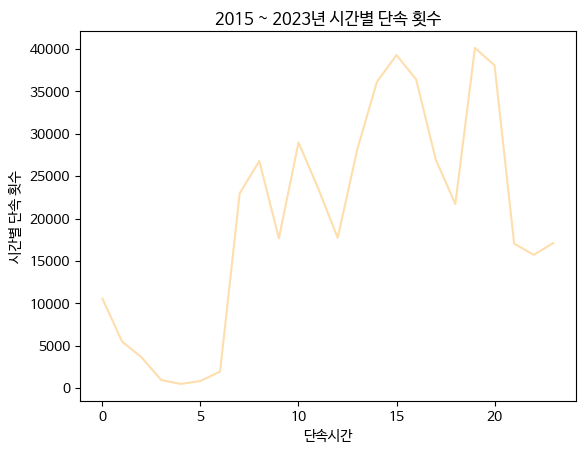

In [30]:
#시간별 단속 횟수
plt.plot(by_hour.index, by_hour['시간별 단속 횟수'], color = 'navajowhite')
plt.xlabel('단속시간')
plt.ylabel('시간별 단속 횟수')
plt.title('2015 ~ 2023년 시간별 단속 횟수')
plt.show()

#2. 시각화: 불법주정차 CCTV 위치

In [32]:
m = folium.Map(location=[37.5385607, 127.0822739],
               zoom_start=14,
               )
# 건대입구역
folium.Marker([37.54041716624373, 127.06914637466906],
              popup='<b>subway</b>',
              tooltip='<i>건대입구역</i>').add_to(m)
#광진구청
folium.Marker([37.5385607, 127.0822739],
              tooltip='<i>광진구청</i>').add_to(m)
m

#3. 선형회귀분석

In [31]:
#종속, 독립변수 데이터 종합
Regression = pd.concat([enforcement_count_2023, cctv_dong, count_parking_public, count_parking_concated], axis = 1)
Regression

,단속동,cctv개수,동명,주소(지번)
구의동,10033,16,8,339
중곡동,9366,12,13,688
자양동,7859,13,5,1003
광장동,4671,4,3,190
군자동,2937,6,2,52
화양동,2561,4,3,158
능동,2283,3,2,162


In [33]:
#상관분석
corr_matrix = Regression.corr()
corr_matrix

,단속동,cctv개수,동명,주소(지번)
단속동,1.000000,0.944075,0.850067,0.693949
cctv개수,0.944075,1.000000,0.724999,0.678898
동명,0.850067,0.724999,1.000000,0.568676
주소(지번),0.693949,0.678898,0.568676,1.000000


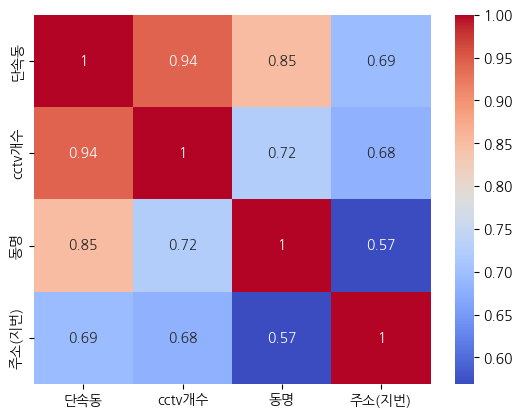

In [34]:
plt.rcParams['font.family'] = 'NanumGothic'
sns.heatmap(corr_matrix, cmap = 'coolwarm', annot = True)
plt.show()

In [35]:
plt.scatter(Regression)

TypeError: ignored

In [37]:
#단순회귀분석
x_cols = cctv_dong
y_cols = enforcement_count_2023

In [38]:
enforcement_train, enforcement_test = train_test_split(Regression, test_size = 0.3)
enforcement_train


,단속동,cctv개수,동명,주소(지번)
중곡동,9366,12,13,688
능동,2283,3,2,162
광장동,4671,4,3,190
자양동,7859,13,5,1003


In [39]:
y_pred = reg.predict(x)
plt.scatter(x, y)
plt.plot(x, y_pred, color = 'red')
plt.xlabel('Number of CCTV')
plt.ylabel('Enforcement Count')
plt.show()

NameError: ignored